In [ ]:
!pip install keras-squeezenet
!pip install tf_slim
!pip install tensorflow
!pip install torch torchvision onnx onnx-tf


  Preparing metadata (setup.py) ... done
  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-py3-none-any.whl size=3567 sha256=90a5de28fa5fdf363ad213e3a62cc39cb2755fc157849004ad9a555e34c80afe
  Stored in directory: /root/.cache/pip/wheels/f1/d0/32/6d82b57a8253f794375a32359dd2f9ee02a6089cad2222bd78
Successfully built keras-squeezenet


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tensorflow.keras.applications import ResNet50
import tensorflow_hub as hub
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

Dataset generation complete.


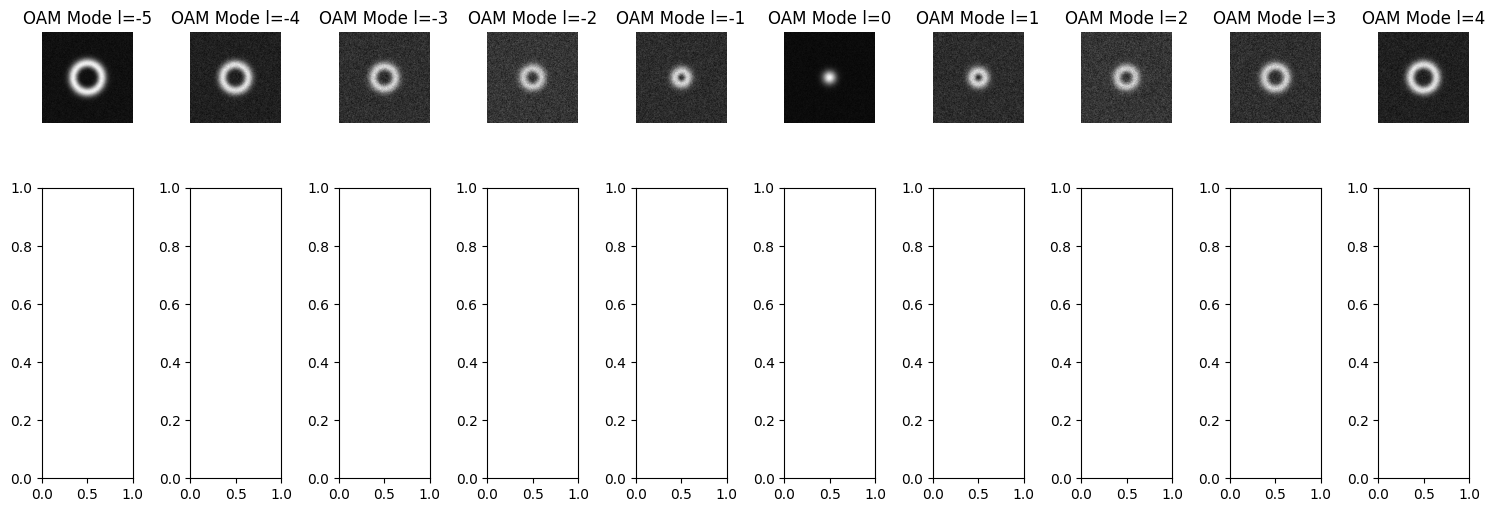

In [ ]:
def laguerre_gaussian_beam(l, p, x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    amplitude = np.exp(-r**2) * np.power(r, np.abs(l))
    phase = np.exp(1j * l * theta)
    return amplitude * phase

def generate_oam_image(l, img_size=256, noise_level=0.1):
    x = np.linspace(-5, 5, img_size)
    y = np.linspace(-5, 5, img_size)
    X, Y = np.meshgrid(x, y)
    beam = laguerre_gaussian_beam(l, 0, X, Y)
    intensity = np.abs(beam)**2
    noise = noise_level * np.random.rand(img_size, img_size)
    noisy_intensity = intensity + noise
    return noisy_intensity

# Set parameters
img_size = 256
num_modes = 10  # Number of different OAM modes
num_images_per_mode = 100  # Number of images per OAM mode
output_dir = '/content/drive/MyDrive/oam_dataset'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate and save images
for l in range(-num_modes//2, num_modes//2):
    mode_dir = os.path.join(output_dir, f'mode_{l}')
    if not os.path.exists(mode_dir):
        os.makedirs(mode_dir)
    for img_num in range(num_images_per_mode):
        img = generate_oam_image(l, img_size)
        img_path = os.path.join(mode_dir, f'oam_mode_{l}_img_{img_num}.png')
        plt.imsave(img_path, img, cmap='gray')

print("Dataset generation complete.")

# Visualize a few images from each mode
fig, axes = plt.subplots(2, num_modes, figsize=(15, 6))
axes = axes.flatten()

for idx, l in enumerate(range(-num_modes//2, num_modes//2)):
    img_path = os.path.join(output_dir, f'mode_{l}', f'oam_mode_{l}_img_0.png')
    img = plt.imread(img_path)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'OAM Mode l={l}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define paths
dataset_dir = '/content/drive/MyDrive/oam_dataset'
train_dir = '/content/drive/MyDrive/oam_dataset_split/train'
val_dir = '/content/drive/MyDrive/oam_dataset_split/val'
test_dir = '/content/drive/MyDrive/oam_dataset_split/test'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Parameters
test_size = 0.15
val_size = 0.15

# Collect all image paths and their corresponding labels
image_paths = []
labels = []

for mode in range(-num_modes // 2, num_modes // 2):
    mode_dir = os.path.join(dataset_dir, f'mode_{mode}')
    for img_name in os.listdir(mode_dir):
        if img_name.endswith('.png'):
            image_paths.append(os.path.join(mode_dir, img_name))
            labels.append(mode)

# Split the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_size, stratify=labels)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=val_size / (1 - test_size), stratify=train_labels)

# Function to save the split dataset
def save_split(paths, labels, split_dir):
    for path, label in zip(paths, labels):
        mode_dir = os.path.join(split_dir, f'mode_{label}')
        os.makedirs(mode_dir, exist_ok=True)
        shutil.copy(path, os.path.join(mode_dir, os.path.basename(path)))

# Save splits
save_split(train_paths, train_labels, train_dir)
save_split(val_paths, val_labels, val_dir)
save_split(test_paths, test_labels, test_dir)

print("Dataset split complete.")


Dataset split complete.


In [2]:
# Directories
train_dir = '/content/drive/MyDrive/oam_dataset_split/train'
val_dir = '/content/drive/MyDrive/oam_dataset_split/val'
test_dir = '/content/drive/MyDrive/oam_dataset_split/test'

# Image size
img_size = 256
batch_size = 32

# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load and preprocess the data
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preprocessing complete.")


Data preprocessing complete.


# ResNet50

In [ ]:
# Image size and batch size
img_size = 224  # Resize to 224x224 as expected by ResNet50
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Build the ResNet50 model
base_model = ResNet50(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Unfreeze the base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('/content/drive/MyDrive/oam_resnet50_model.h5')


Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/25
22/22 [==============================] - 22s 777ms/step - loss: 2.3530 - accuracy: 0.0843 - val_loss: 2.3201 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - 14s 621ms/step - loss: 2.3314 - accuracy: 0.0843 - val_loss: 2.2800 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - 15s 680ms/step - loss: 2.2985 - accuracy: 0.0886 - val_loss: 2.2502 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - 14s 650ms/step - loss: 2.2704 - accuracy: 0.1186 - val_loss: 2.2350 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 5/25
22/22 [==============================] - 14s 657ms/step - loss: 2.2633 - accuracy: 0.1914 - val_loss: 2.2282 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/25
22/22 [===========

In [ ]:
# Image size and batch size
img_size = 224  # Resize to 224x224 as expected by ShuffleNetV2
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Build the ShuffleNetV2 model using TensorFlow Hub
def build_shufflenet_model(img_size, num_classes):
    # Load the pre-trained model from TensorFlow Hub
    shufflenet_url = "https://tfhub.dev/google/imagenet/shufflenet_v2_0.5_224/classification/4"
    base_model = hub.KerasLayer(shufflenet_url, input_shape=(img_size, img_size, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom output layers
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Define the number of classes
num_classes = len(train_generator.class_indices)

# Build the model
model = build_shufflenet_model(img_size, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Unfreeze the base model layers for fine-tuning (optional)
for layer in model.layers[0].layers:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning (optional)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('/content/drive/MyDrive/oam_shufflenet_model.h5')


# DenseNet

In [ ]:
# Image size and batch size
img_size = 224  # Resize to 224x224 as expected by DenseNet121
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Build the DenseNet121 model
base_model = DenseNet121(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Unfreeze the base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('/content/drive/MyDrive/oam_densenet_model.h5')


Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Epoch 1/25
22/22 [==============================] - 25s 844ms/step - loss: 2.1791 - accuracy: 0.2000 - val_loss: 1.8812 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - 14s 639ms/step - loss: 1.6028 - accuracy: 0.4429 - val_loss: 1.5697 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - 14s 634ms/step - loss: 1.3677 - accuracy: 0.4986 - val_loss: 1.4371 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - 14s 658ms/step - loss: 1.2652 - accuracy: 0.5000 - val_loss: 1.3683 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/25
22/22 [==============================] - 14s 646ms/step - loss: 1.1777 - accuracy: 0.5557 - val_loss: 1.2565 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 6/25
22/22 [==============================] - 14s 654ms/step - loss: 1.1183 - accuracy: 

# AlexNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Image size and batch size
img_size = 224  # Resize to 224x224 for consistency
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Build the AlexNet model
model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('/content/drive/MyDrive/oam_alexnet_model.h5')


Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Epoch 1/25
22/22 [==============================] - 23s 640ms/step - loss: 2.4647 - accuracy: 0.0914 - val_loss: 2.2918 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - 19s 882ms/step - loss: 2.2747 - accuracy: 0.1157 - val_loss: 2.2036 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - 18s 843ms/step - loss: 1.9998 - accuracy: 0.1986 - val_loss: 1.8720 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - 23s 1s/step - loss: 1.8504 - accuracy: 0.2300 - val_loss: 1.6627 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/25
22/22 [==============================] - 16s 695ms/step - loss: 1.5588 - accuracy: 0.3157 - val_loss: 1.3151 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 6/25
22/22 [==============================] - 15s 663ms/step - loss: 1.2951 - accuracy: 0.4

# MobileNetv2

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

# Directories
train_dir = '/content/drive/MyDrive/oam_dataset_split/train'
val_dir = '/content/drive/MyDrive/oam_dataset_split/val'
test_dir = '/content/drive/MyDrive/oam_dataset_split/test'

# Image size and batch size
img_size = 224  # Resize to 224x224 as expected by MobileNetV2
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Build the MobileNetV2 model using TensorFlow Hub
def build_model(img_size, num_modes):
    # Load the pre-trained model from TensorFlow Hub
    base_model = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                                input_shape=(img_size, img_size, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom output layers
    model = Sequential([
        base_model,
        Dense(128, activation='relu'),
        Dense(num_modes, activation='softmax')
    ])

    return model

# Define the number of modes (classes)
num_modes = 10

# Build the model
model = build_model(img_size, num_modes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('/content/drive/MyDrive/oam_mobilenetv_2_2_model.h5')


Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2423242 (9.24 MB)
Trainable params: 165258 (645.54 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 29s 887ms/step - loss: 1.6502 - accuracy: 0.3986 - val_loss: 1.4490 - val_accuracy: 0.4133
Epoch 2/

# WideResNet

In [22]:
# Image size and batch size
img_size = 224  # Resize to 224x224 as expected by WideResNet
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Build the WideResNet model
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')

# Modify ResNet to be WideResNet by adding extra filters to each convolutional layer
# Note: WideResNet usually doubles the number of filters in each layer compared to the original ResNet

# Build custom WideResNet model
def wide_resnet_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = wide_resnet_model(base_model, len(train_generator.class_indices))

# Freeze the base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Unfreeze the base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('/content/drive/MyDrive/oam_wideresnet_model.h5')


Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/25
22/22 [==============================] - 18s 685ms/step - loss: 2.3430 - accuracy: 0.0943 - val_loss: 2.2852 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - 14s 636ms/step - loss: 2.3074 - accuracy: 0.1314 - val_loss: 2.2810 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - 15s 697ms/step - loss: 2.2884 - accuracy: 0.1571 - val_loss: 2.2462 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - 14s 635ms/step - loss: 2.2738 - accuracy: 0.1486 - val_loss: 2.2463 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/25
22/22 [==============================] - 14s 632ms/step - loss: 2.2573 - accuracy: 0.1757 - val_loss: 2.2057 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 6/25
22/22 [===========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model's Comparison

In [ ]:
# Directories
test_dir = '/content/drive/MyDrive/oam_dataset_split/test'

# Image size and batch size
img_size = 224
batch_size = 32

# Data generator for test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Function to evaluate a model
def evaluate_model(model_path, test_generator):
    # Register the KerasLayer as a custom object
    model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})
    predictions = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1

# Paths to the saved models
models = {
    'DenseNet': '/content/drive/MyDrive/oam_densenet_model.h5',
    'AlexNet': '/content/drive/MyDrive/oam_alexnet_model.h5',
    'MobileNetv2': '/content/drive/MyDrive/oam_mobilenetv_2_2_model.h5',
    'ResNet': '/content/drive/MyDrive/oam_resnext_model.h5',
    'WideResNet': '/content/drive/MyDrive/oam_wideresnet_model.h5'
}

# Evaluate all models and store results in a DataFrame
results = []

for model_name, model_path in models.items():
    try:
        accuracy, precision, recall, f1 = evaluate_model(model_path, test_generator)
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    except Exception as e:
        print(f"Error evaluating model {model_name}: {e}")
        results.append({
            'Model': model_name,
            'Accuracy': None,
            'Precision': None,
            'Recall': None,
            'F1 Score': None
        })

results_df = pd.DataFrame(results)
print(results_df)


Found 150 images belonging to 10 classes.
5/5 [==============================] - 2s 246ms/step
         Model  Accuracy  Precision    Recall  F1 Score
0     DenseNet  0.600000   0.504228  0.600000  0.531650
1      AlexNet  0.100000   0.010000  0.100000  0.018182
2  MobileNetv2  0.506667   0.414097  0.506667  0.390158
3       ResNet  0.100000   0.010000  0.100000  0.018182
4   WideResNet  0.100000   0.010000  0.100000  0.018182


# Model chaining

In [ ]:
# This section is in progress

img_size = 224  # Resize to 224x224 for consistency
batch_size = 32

# Data augmentation and normalization for all models
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and preprocess the data for all models
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Load DenseNet121 model
base_model_densenet = tf.keras.models.load_model('/content/drive/MyDrive/oam_densenet_model.h5')

# Load AlexNet model
base_model_alexnet = tf.keras.models.load_model('/content/drive/MyDrive/oam_alexnet_model.h5')#

# Load MobileNetV2 model
base_model_mobilenet = tf.keras.models.load_model('/content/drive/MyDrive/oam_mobilenetv_2_2_model.h5')#

# Load WideResNet model
base_model_wideresnet = tf.keras.models.load_model('/content/drive/MyDrive/oam_wideresnet_model.h5')#

# Load ResNet50 model
base_model_resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/oam_resnet50_model.h5')

# Define input tensors
input_tensor = Input(shape=(img_size, img_size, 3))

# Extract output tensors
output_densenet = base_model_densenet(input_tensor)
output_alexnet = base_model_alexnet(output_densenet)
output_mobilenet = base_model_mobilenet(output_alexnet)
output_wideresnet = base_model_wideresnet(output_mobilenet)
output_resnet50 = base_model_resnet50(output_wideresnet)

# Create your final model
final_model = Model(inputs=input_tensor, outputs=output_resnet50)

# Compile the model
final_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = final_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_acc = final_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the model
final_model.save('/content/drive/MyDrive/oam_multi_model_chain.h5')
